In [1]:
import numpy
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# GARANTE O FORMATO DAS COLUNAS PARA ARRAYS UNIDIMENSIONAIS
def reshape(df):
    # CASO NÃO HAJA INFORMAÇÕES EM SHAPE, EX.: SHAPE(X) = (#, )
    if len(df.shape) < 2:
        # FORÇA O FORMATO SHAPE(X) = (#, 1)
        return numpy.reshape(df, (df.shape[0], 1))
    else:
        # SENÃO, NÃO ALTERE O FORMATO DOS DADOS
        return df
    
# MATRIZ DE PESOS DE ENTRADA
def input_weights(N = 10, K = 1, input_scaling = 1):
    # CRIA UMA MATRIZ DE DIMENSÕES N x (K + 1)
    # DISTRIBUIÇÃO DE VALORES UNIFORMES ENTRE (SCALE x -0.5, SCALE x 0.5)
    return((numpy.random.rand(N, 1 + K) - 0.5) * input_scaling)

# MATRIZ DE PESOS DE RESERVATÓRIO
def reservoir_weights(N = 10, spectral_radius = 1.00, sparsity = 0):
    # CRIA UMA MATRIZ DE DIMENSÕES N x N
    # DISTRIBUIÇÃO DE VALORES UNIFORMES ENTRE (-0.5, 0.5)
    w = numpy.random.rand(N, N) - 0.5
    # CALCULA O MAIOR AUTOVALOR ABSOLUTO DA MATRIZ DE PESOS
    # FORÇA O AUTOVALOR DA MATRIZ PARA 1 E ESCALONA PELO RAIO ESPECTRAL DESEJADO
    w *= spectral_radius / numpy.max(numpy.abs(linalg.eig(w)[0]))
    # APLICA ESPARSIDADE NA MATRIZ
    w[numpy.random.rand(N, N) < sparsity] = 0
    return(w)

# MATRIZ DE ESTADOS
def create_states(dim = 1, patterns = 100):
    # CRIA UMA MATRIZ DE ESTADOS ZERADA
    return(numpy.zeros((dim, patterns)))

# HARVESTING -> ATUALIZAÇÃO DOS ESTADOS
def harvesting_states(state_matrix, input_patterns, win, wres, initial_state, leaking = 0.5, transiente = 0):
    # ESTADO INICIAL DO MODELO, EM CASO DE TRAINNING O ESTADO É POR DEFAULT ZERO PARA TODOS OS NEURÔNIOS
    state = initial_state.copy()
    for n in range(input_patterns.shape[0]):
        # CADA PADRÃO DE INPUT
        u = input_patterns[n,:]
        # ATUALIZA OS ESTADOS CONFORME A EQUAÇÃO DE ATUALIZAÇÃO
        state = (1 - leaking)*state + leaking*numpy.tanh(numpy.dot(win, reshape(numpy.hstack((1, u)))) + numpy.dot(wres, state))
        if n >= transiente:
            # DESCARTA O TRANSIENTE, REPASSA OS VALORES DE ESTADOS OBTIDOS
            state_matrix[:, n - transiente] = numpy.hstack((1, u, state[:,0]))
    return(state_matrix)

# REGRESSÃO DE RIDGE
def ridge_regression(states, target, reg = 1e-8):
    # RESOLVE A PROJEÇÃO DOS ESTADOS NO "TARGET" (OUTPUT DESEJADO)
    return(linalg.solve(numpy.dot(states, states.T) + reg * numpy.eye(states.shape[0]), 
                        numpy.dot(states, target.T)).T[0]
          )

# ALTERA O DATASET ORIGINAL, CONFORME O NÚMERO DE JANELAS DESEJADAS
def set_window(name = "NormHenon.txt", window_len = 1, begin = 0):
    # REALIZA A LEITURA DO ARQUIVO
    df = reshape(numpy.loadtxt(name, delimiter = ","))
    # CORTA O DATAFRAME NO PONTO DESEJADO
    df = df[begin:df.shape[0],:]
    # CALCULA TAMANHO DE JANELA x DIMENSÃO DA JANELA
    x = df.shape[1] * window_len
    # CRIA REFERÊNCIA INICIAL
    windows = df.copy()[0:df.shape[0]-(window_len - 1),:]
    for j in range(1, window_len):
        # CONCATENA O DATAFRAME SHIFITADO
        windows = numpy.hstack([windows, df.copy()[j:j+windows.shape[0],:]])
    return(windows, x)

In [3]:
# TAMANHO DE JANELA DE ENTRADA (INPUT)
len_window_input = 3
# TAMANHO DE JANELA DE SAÍDA (OUTPUT)
len_window_output = 1

# PASSOS AHEAD QUE DESEJAMOS PREVER
steps = 1

# TAMANHO DA JANELA DE TRAINNING
train_length = 4000
# TAMANHO DA JANELA DE TESTING
test_length = 1000

# TRANSIENTE, VALORES A SEREM DESCARTADOS
transiente = 1000

# NÚMERO DE NEURÔNIOS NA CAMADA OCULTA, INT, N > 0
N = 200
# TAXA DE VAZAMENTO ESPECTRAL, FLOAT, NO CONJUNTO (0, 1]
leaking_rate = 0.5
# ESPARSIDADE DA MATRIZ, FLOAT, NO CONJUNTO [0, 1]
sparsity = 0.0
# ESCALA DOS DADOS DE ENTRADA, FLOAT, NO CONJUNTO (0, INF)
input_scaling = 1
# RAIO ESPECTRAL DESEJADO, FLOAT, NO CONJUNTO (0, INF)
spectral_radius = 0.5

In [4]:
# INPUT DO SISTEMA
input_dataset, K = set_window(name = "series_henon_norm.txt", window_len = len_window_input, begin = 0)
# OUTPUT ESPERADO
output_dataset, L = set_window(name = "series_henon_norm.txt", window_len = len_window_output, begin = len_window_input)

# DATASET DE TREINO -> [(X0), (X1), (X2), ..., (Xjanela_treino-1)]
train_dataset = input_dataset[0 : train_length, :]
# DATASET DE TREINO (TARGET) -> [(Ysteps+transiente), (Ysteps+transiente+1), ..., (Ysteps+janela_treino-1)]
train_target = output_dataset[None, steps + transiente - 1 : train_length + steps - 1, :]

# DATASET DE TESTE -> [(Xjanela_treino), (Xjanela_treino+1), (Xjanela_treino+2), ..., (Xjanela_treino+janela_teste-1)]
test_dataset = input_dataset[train_length : train_length + test_length, :]
# DATASET DE TESTE (TARGET) -> [(Ysteps+janela_treino+janela_teste), ..., (Ysteps+janela_treino+janela_teste-1)]
test_target = output_dataset[train_length + steps - 1 : train_length + test_length + steps - 1, :].T

In [5]:
input_dataset

array([[-0.50345012, -0.50072158,  1.1035704 , -0.50072158, -0.97664434,
         1.10224828],
       [ 1.1035704 , -0.50072158, -0.97664434,  1.10224828,  1.24817774,
        -0.97682568],
       [-0.97664434,  1.10224828,  1.24817774, -0.97682568, -1.32500153,
         1.25033516],
       ...,
       [-0.76217653, -1.61600709,  0.42538895, -0.76050423,  0.0672094 ,
         0.41892809],
       [ 0.42538895, -0.76050423,  0.0672094 ,  0.41892809,  1.03471082,
         0.06385679],
       [ 0.0672094 ,  0.41892809,  1.03471082,  0.06385679, -0.72623223,
         1.03204793]])

In [6]:
output_dataset

array([[ 1.24817774, -0.97682568],
       [-1.32500153,  1.25033516],
       [ 0.31606186, -1.32583368],
       ...,
       [ 0.0672094 ,  0.41892809],
       [ 1.03471082,  0.06385679],
       [-0.72623223,  1.03204793]])

In [7]:
train_dataset

array([[-0.50345012, -0.50072158,  1.1035704 , -0.50072158, -0.97664434,
         1.10224828],
       [ 1.1035704 , -0.50072158, -0.97664434,  1.10224828,  1.24817774,
        -0.97682568],
       [-0.97664434,  1.10224828,  1.24817774, -0.97682568, -1.32500153,
         1.25033516],
       ...,
       [ 0.86624938,  0.12923607, -0.41309421,  0.86113568,  1.6000105 ,
        -0.41079576],
       [-0.41309421,  0.86113568,  1.6000105 , -0.41079576, -1.72740329,
         1.61454086],
       [ 1.6000105 , -0.41079576, -1.72740329,  1.61454086, -1.17371478,
        -1.71939559]])

In [8]:
train_target

array([[[ 0.94502104, -1.12608998],
        [-0.90392384,  0.94090928],
        [ 1.33015928, -0.90349501],
        ...,
        [-1.72740329,  1.61454086],
        [-1.17371478, -1.71939559],
        [-0.28592427, -1.17490563]]])

In [9]:
# DEFINE UMA SEMENTE DO GERADOR PSEUDO-ALEATORIO
numpy.random.seed(42)

# PESOS DE ENTRADA
W_input = input_weights(N = N, K = K, input_scaling = input_scaling)
# PESOS DE RESERVATORIO
W_reservoir = reservoir_weights(N = N, spectral_radius = spectral_radius, sparsity = sparsity)

# MATRIZ DE ESTADOS (TRAINNING)
state_matrix = harvesting_states(state_matrix = create_states(dim = 1 + K + N, patterns = train_length - transiente), 
                                 input_patterns = train_dataset, 
                                 win = W_input, 
                                 wres = W_reservoir, 
                                 initial_state = numpy.zeros((N, 1)),
                                 leaking = leaking_rate, 
                                 transiente = transiente)

# PESOS DE SAÍDA
W_output = ridge_regression(states = state_matrix, target = train_target)

In [10]:
# O ESTADO INICIAL É O ÚLTIMO ESTADO DO TREINAMENTO
initial_state = reshape(state_matrix[K + 1::,-1])

# MATRIX DE ESTADOS (TESTING)
state_matrix = harvesting_states(state_matrix = create_states(dim = 1 + K + N, patterns = test_length), 
                                 input_patterns = test_dataset, 
                                 win = W_input, wres = W_reservoir, 
                                 initial_state = initial_state,
                                 leaking = leaking_rate, 
                                 transiente = 0)

# PREDIÇÃO
predict = numpy.dot(W_output, state_matrix)

In [11]:
test_dataset

array([[-1.72740329,  1.61454086, -1.17371478, -1.71939559, -0.28592427,
        -1.17490563],
       [-1.17371478, -1.71939559, -0.28592427, -1.17490563,  0.71483788,
        -0.28481452],
       [-0.28592427, -1.17490563,  0.71483788, -0.28481452, -0.25854108,
         0.70847997],
       ...,
       [ 0.35325567, -0.01025814,  0.45779304,  0.34717763,  0.39352527,
         0.45120891],
       [ 0.45779304,  0.34717763,  0.39352527,  0.45120891,  0.53770384,
         0.38721553],
       [ 0.39352527,  0.45120891,  0.53770384,  0.38721553,  0.26214781,
         0.53095367]])

In [12]:
test_target

array([[ 0.71483788, -0.25854108,  1.47216147, ...,  0.53770384,
         0.26214781,  0.78221659],
       [-0.28481452,  0.70847997, -0.25774533, ...,  0.38721553,
         0.53095367,  0.25674959]])

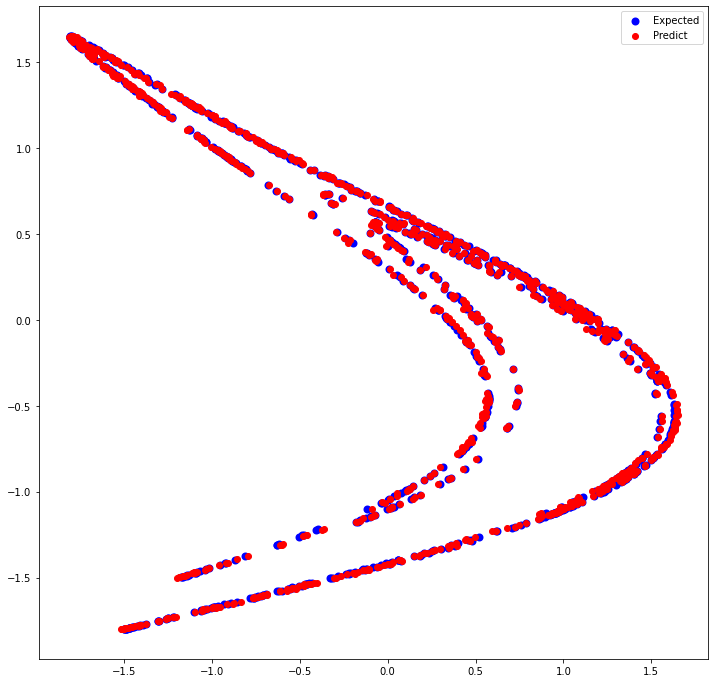

In [13]:
plt.figure(figsize=(12,12))
plt.scatter(test_target[0,:], test_target[1,:], color = "blue", linewidth = 2, label = "Expected")
plt.scatter(predict[0,:], predict[1,:], color = "red", linewidth = 1, label = "Predict")
plt.legend()
plt.show()

In [14]:
mean_squared_error(test_target, predict)

4.884986761312109e-05

In [15]:
mean_squared_error(test_target, predict, squared = False)

0.0053428082166881285

In [16]:
mean_absolute_percentage_error(test_target, predict)

0.026974693714153345